**Preprocessamento do modelo.**

                                Visão Geral
Estamos usando imagens de raio-X dos pulmões com pneumonia e pulmões saudáveis.
Atualmente, temos 26.684 imagens de raio-X:

20.672 imagens sem pneumonia, o que equivale a aproximadamente 77%.
6.012 imagens com pneumonia, o que equivale a aproximadamente 22%. Nesse caso, temos um conjunto de dados desequilibrado.
As imagens estão no formato de 1024x1024, vamos redimensioná-las para 244x244 devido às limitações de hardware atual.

Também vamos Normalizar e Padronizar as imagens de raio-X.

Padronizar os valores dos pixels no intervalo de [0,1], escalando com 1/255.

Dividir 24.000 imagens para treinamento e 2.684 para Validação.

Armazenar as imagens convertidas em pastas correspondentes à classe 1 se houver pneumonia / 0 se estiver saudável.

Finalmente, vamos Normalizar as imagens calculando a média e o desvio padrão.


Como nossos dados estão desequilibrados existem 3 maneiras de lidar:


1: A primeira possibilidade é não fazer nada(Funciona em alguns casos).

2: Você pode usar weighted loss função, é designado uma perda maior para a previsão do modelo, se o modelo erradamente preve a classe negativa.

3: Oversampling, quando se usa oversampling, o objetivo geral é mostrar à rede tantas amostras da classe um quanto da classe zero.



In [1]:
##Might give a warning
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

Informações de cada scan, o "Target" mostra em binário se o paciente tem pneumonia(1) ou não(0)

In [5]:
labels = pd.read_csv("stage_2_train_labels.csv")
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


Como pode ver, existem duplicidade acima, para remover use o seguinte:

In [6]:
labels = labels.drop_duplicates("patientId")

In [7]:
labels = pd.read_csv("stage_2_train_labels.csv")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Definição de caminho:

In [8]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed")

Imagens de exemplo.

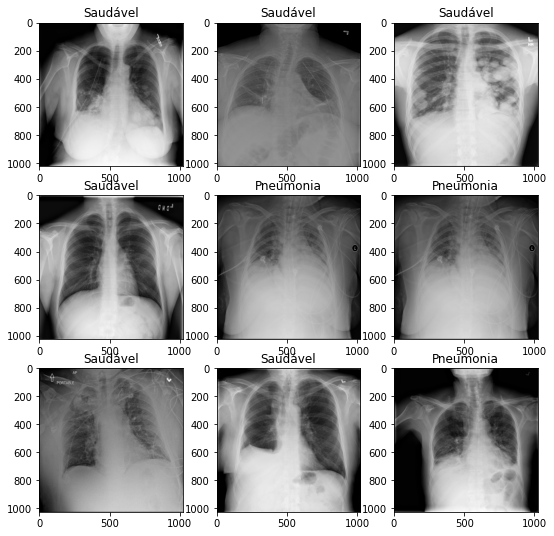

In [15]:
fig, axis = plt.subplots(3, 3, figsize=(9,9))
c=0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c] ##Each row
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_path).pixel_array
        label = labels["Target"].iloc[c]
        ##Visualization purposes
        if (label == 1):
            pn = "Pneumonia"
        else:
            pn = "Saudável"
        ##--
        axis[i][j].imshow(dcm, cmap="gray")
        axis[i][j].set_title(pn)
        c+=1
        

**Ler dicom e Armazenamento inteligente**

Em ordem para armazenar nossos dados, convertemos imagens de raio-x para arrays de numpy, depois computamos a média e o desvio padrão dos pixels de todo  
dataset, no proposito de normalização, então as imagens são guardadas em duas pastas separadas de acordo com seu rótulo binario:
- 0: Todos os raio-x que não tem sinais de pneumonia
- 1: Todos os raio-x que tem sinais de pneumonia.
 

In [1]:
sums = 0
sums_squared = 0
for c, patient_id in enumerate(tqdm(labels.patientId)): ##Tqdm for loading visualization.
    dcm_path = ROOT_PATH/patient_id
    dcm_path = dcm_path.with_suffix(".dcm")
    
    dcm = pydicom.read_file(dcm_path).pixel_array / 255
    #Resize the dicom 224x224 as the type of a float 16,
    #Because current hardware can`t handle it 1024x1024.
    dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
    label = labels.Target.iloc[c]
    
    #4/5 train split, 1/5 Validation split.
    train_or_val = "train" if c < 24000 else "val"
    
    current_save_path = SAVE_PATH/train_or_val/str(label)
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)
    
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]
    if train_or_val == "train":
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum())

NameError: name 'tqdm' is not defined

In [17]:
mean = sums / 2400
std = np.sqrt(sums_squared / 24000 - (mean**2))

Nós usaremos a média e o desvio padrão para normalizar nossos dados.

In [18]:
print(f"Media/Mean: {mean}, Desvio padrão/STD: {std}")

Media/Mean: 4.88908784412202, Desvio padrão/STD: 122.51792805566237
